In [100]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

class ZBL():

    def __init__(self, Zi, Zj):
        
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi

    def eval_grad(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])
            
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)

In [101]:
class Fitting_Potential():

    def __init__(self, hyperparams):

        # Decompose Sample as follows: [ F, Rho, W-He, H-He, He-He ]

        # For F the knots are: [0, rho_1 ... rho_f, rho_c], [0, F(rho_1) ... F(rho_f), F(rho_c)] f + 2 is the number knot points requires: 2f + 1 params 

        # For Rho the knots are: [0, r_1 ... r_rho, r_c], [0, Rho(r_1) ... Rho(r_rho), Rho(r_c)] rho + 2 is the number knot points requires: 2rho + 1 params

        # For V (pair pot) are: [0, r_1 ... r_v, r_c], [0, V(r_1) ... V(r_v), -Z(r_c)] v + 2 is the number knot points requires: 2v params

        self.keys  = ['He_F(rho)','He_rho(r)', 'W-He', 'H-He', 'He-He']
        self.items = ['knot_pts', 'knot_val']

        self.hyper = hyperparams

        self.nf = 0
        self.nrho = 0
        self.nv = 3

        self.map = {}

        map_idx = [self.nf, self.nf + 1] + [self.nrho, self.nrho + 1] + 3*[self.nv, self.nv]

        trunc_map_idx = [self.nf + 1] + [self.nrho + 1] + 3*[self.nv]

        idx = 0
        iter = 0
        for key in self.keys:
            self.map[key] = {}
            for item in self.items:
                self.map[key][item] = slice(idx, idx + map_idx[iter])
                idx += map_idx[iter]
                iter += 1 
        self.len_sample = idx

        idx = 0
        iter = 0
        self.trunc_map = {}

        for key in self.keys:
            self.trunc_map[key] = slice(idx, idx + trunc_map_idx[iter])
            idx += trunc_map_idx[iter]
            iter += 1
    
    def sample_to_array(self, sample_dict):
        
        sample_lst = []

        for key in self.keys:

            for item in self.items:

                for val in sample_dict[key][item]:

                    sample_lst.append(val)

        return np.array(sample_lst)
    
    def array_to_sample(self, sample_arr):
        
        sample_dict = {}

        for key in self.keys:
            sample_dict[key] = {}
            for item in self.items:
                sample_dict[key][item] = sample_arr[self.map[key][item]]

        return sample_dict

    def truncate_sample(self, sample):
        
        sample_lst = []
        
        for key in self.keys:
            
            for val in sample[self.map[key]['knot_val']]:

                sample_lst.append(val)
            
        return np.array(sample_lst)

    def extend_sample(self, sample):

        sample_lst = []

        knot_lst = [np.linspace(0, self.hyper['rho_c'], self.nf + 2)[1:-1], np.linspace(0, self.hyper['rc'], self.nrho + 2)[1:-1],  
                    np.array([2.0376, 2.8161, 3.6429]), np.array([1.4841, 2.3047, 3.6429]), np.array([1.4841, 2.3047, 3.6429])]
        
        for i, key in enumerate(self.keys):
            
            for knot_pt in knot_lst[i]:

                sample_lst.append(knot_pt)
            
            for knot_val in sample[self.trunc_map[key]]:
                
                sample_lst.append(knot_val)
        
        return np.array(sample_lst)

    def init_sample(self, isrand = False):

        sample = np.zeros((self.len_sample,))

        if isrand:
            
            sample = self.gen_rand()

        else:
            
            with open("../Init.json", "r") as json_file:
                loaded_data = json.load(json_file)

            ref = {}
            for key, value in loaded_data.items():
                ref[key] = np.array(value)

            # Initialize based on prior beliefs
            # Knot points are equispaced in the given range

            sample[self.map['He_F(rho)']['knot_pts']] = np.linspace(0, self.hyper['rho_c'], self.nf + 2)[1:-1]

            # Assume linear relationship between F and rho
            sample[self.map['He_F(rho)']['knot_val']] = 0.37*np.linspace(0, self.hyper['rho_c'], self.nf + 2)[1:]

            
            sample[self.map['He_rho(r)']['knot_pts']] = np.linspace(0, self.hyper['rc'], self.nrho + 2)[1:-1]
            
            # Assume that the electron density is zero
            sample[self.map['He_rho(r)']['knot_val']] = np.zeros((self.nrho + 1,))

            charge = np.array([[74, 2],
                              [1, 2],
                              [2, 2]])
            
            knot_pts = np.array([[2.0376, 2.8161, 3.6429],
                                [1.4841, 2.3047, 3.6429],
                                [1.4841, 2.3047, 3.6429]])
            
            for i, key in enumerate(['W-He', 'H-He', 'He-He']):
                
                zbl = ZBL(charge[i,0], charge[i,1])
                
                sample[self.map[key]['knot_pts']] = knot_pts[i]
                
                idx = np.floor(sample[self.map[key]['knot_pts']]/self.hyper['dr']).astype(int)

                sample[self.map[key]['knot_val']] = ref[key][idx]/sample[self.map[key]['knot_pts']] - zbl.eval_zbl(sample[self.map[key]['knot_pts']])

        return sample
    
    def gen_rand(self):
            
        sample = np.zeros((self.len_sample,))
        
        # Randomly Generate Knot Points for F(rho)
        sample[self.map['He_F(rho)']['knot_pts']] = np.linspace(0, self.hyper['rho_c'], self.nf + 2)[1:-1]

        # Randomly Generate Knot Values for F(rho)
        sample[self.map['He_F(rho)']['knot_val']] = self.hyper['rho_c']*np.random.rand(self.nf + 1)


        sample[self.map['He_rho(r)']['knot_pts']] = np.linspace(0, self.hyper['rc'], self.nrho + 2)[1:-1]

        # Randomly Generate Knot Values for Rho(r)
        sample[self.map['He_F(rho)']['knot_val']] = np.random.randn(self.nrho + 1)

        
        # Randomly Generate Knot Points for V(r)
        knot_pts = np.array([[2.0376, 2.8161, 3.6429],
                            [1.4841, 2.3047, 3.6429],
                            [1.4841, 2.3047, 3.6429]])
        
        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            sample[self.map[key]['knot_pts']] = knot_pts[i]

            # Randomly Generate Knot Values for Rho(r)
            scale = 2
            shift = 0.5

            sample[self.map[key]['knot_val']] = scale*(np.random.rand(self.nv) - shift)
    
        return sample
    
    def polyfit(self, x_arr, y_arr, dy_arr, d2y_arr):
        
        n_none = 0

        for lst in [y_arr, dy_arr, d2y_arr]:
            
            lst = lst.tolist()
            n_none += lst.count(None)
        
        dof = 3*len(x_arr) - n_none

        Phi = []
        Y   = []

        for i, x in enumerate(x_arr):

            y = y_arr[i]
            dy = dy_arr[i]
            d2y = d2y_arr[i]

            if y is not None:
                Phi.append(np.array([x**i for i in range(dof)]).T)
                Y.append(y)

            if dy is not None:
                Phi.append(np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T)
                Y.append(dy)

            if d2y is not None:
                Phi.append(np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T)
                Y.append(d2y)
            
        Phi = np.array(Phi)

        Y  = np.array(Y)

        return np.linalg.solve(Phi, Y)

    def polyval(self, x, coef, func = True, grad = False, hess = False):

        dof = len(coef)

        if func:
            Phi = np.array([x**i for i in range(dof)]).T
        
        elif grad:
            Phi = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        elif hess:
            Phi = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        if x.ndim == 1:
            return np.dot(Phi, coef)

        else:
            return np.dot(Phi, coef.reshape(-1,1)).flatten()
    
    def fit_sample(self, sample):

        coef_dict = {}

        x = np.linspace(0, self.hyper['rho_c'], self.nf + 2)

        x[1:-1] = sample[self.map['He_F(rho)']['knot_pts']]

        y = np.zeros((self.nf + 2,))

        y[1:] = sample[self.map['He_F(rho)']['knot_val']]

        dy = np.full(y.shape, None, dtype=object)

        d2y = np.full(y.shape, None, dtype=object)

        coef_dict['He_F(rho)'] = self.polyfit(x, y, dy, d2y)


        x = np.linspace(0, self.hyper['rc'], self.nrho + 2)

        x[1:-1] = sample[self.map['He_rho(r)']['knot_pts']]

        y = np.zeros((self.nrho + 2,))

        y[:-1] = sample[self.map['He_rho(r)']['knot_val']]

        dy = np.full(y.shape, None)

        d2y = np.full(y.shape, None)

        dy[-1] = 0

        d2y[-1] = 0

        coef_dict['He_rho(r)'] = self.polyfit(x, y, dy, d2y)

        charge = [[74, 2],[1, 2],[2, 2]]

        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            zbl_class = ZBL(charge[i][0], charge[i][1])
            
            x = np.linspace(0, self.hyper['rc'], self.nv + 2)

            x[1:-1] = sample[self.map[key]['knot_pts']]

            y = np.zeros((self.nv + 2,))

            y[1:-1] = sample[self.map[key]['knot_val']]

            dy = np.full(y.shape, None)

            d2y = np.full(y.shape, None)

            dy[0] = 0

            d2y[0] = 0

            y[-1] = -zbl_class.eval_zbl(x[-1])[0]

            dy[-1] = -zbl_class.eval_grad(x[-1])[0]

            d2y[-1] = -zbl_class.eval_hess(x[-1])[0]

            coef_dict[key] = self.polyfit(x, y, dy, d2y)

        return coef_dict
    
    def sample_to_file(self, coef_dict, pot_file = '../Init.json', output_file = 'Potentials/iteration.eam.alloy'):

        with open(pot_file, "r") as json_file:
            loaded_data = json.load(json_file)

        pot = {}
        for key, value in loaded_data.items():
            pot[key] = np.array(value)
        
        rho = np.linspace(0, self.hyper['rho_c'], self.hyper['Nrho'])

        r = np.linspace(0, self.hyper['rc'], self.hyper['Nr'])

        pot['He_F(rho)'] = self.polyval(rho, coef_dict['He_F(rho)'], func = True, grad = False, hess = False)
        pot['He_rho(r)'] = self.polyval(r, coef_dict['He_rho(r)'], func = True, grad = False, hess = False)

        charge = [[74, 2],[1, 2],[2, 2]]
        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            zbl_class = ZBL(charge[i][0], charge[i][1])
            zbl = zbl_class.eval_zbl(r[1:])

            poly = self.polyval(r[1:], coef_dict[key], func = True, grad = False, hess = False)

            pot[key][1:] = r[1:]*(zbl + poly)

        return pot


In [102]:
pot_params = {}

pot_params['Nrho'] = 10000
pot_params['drho'] = 0.0019792116    
pot_params['Nr']   = 5000
pot_params['dr']   = 0.0009702778    
pot_params['rc']  = 4.8513889200
pot_params['rho_c']  = pot_params['Nrho'] * pot_params['drho']

rho = np.linspace(0, pot_params['rho_c'], pot_params['Nrho'])
r = np.linspace(0, pot_params['rc'], pot_params['Nr'])

print(rho[-1], pot_params['rho_c'])

19.792116 19.792116


In [103]:
inst = Fitting_Potential(pot_params)

sample = inst.init_sample(isrand = True)

trunc_sample = inst.truncate_sample(sample)
sample = inst.extend_sample(trunc_sample)
coef = inst.fit_sample(sample)

pot = inst.sample_to_file(coef)

Text(0, 0.5, 'Energy /eV')

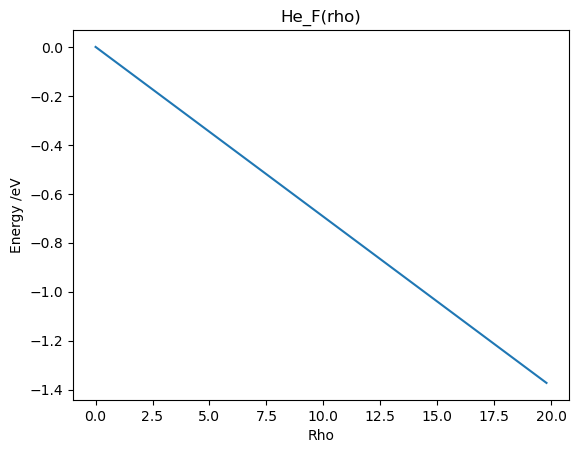

In [104]:
k = 0
key = 'He_F(rho)'
plt.plot(rho[k:], pot[key][k:])
plt.title(key)
plt.xlabel('Rho')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Electron Density')

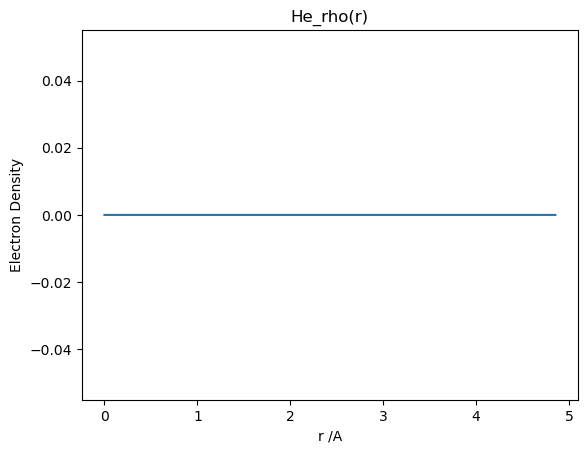

In [105]:
k = 0
key = 'He_rho(r)'
plt.plot(r[k:], pot[key][k:])
plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Electron Density')

Text(0, 0.5, 'Energy /eV')

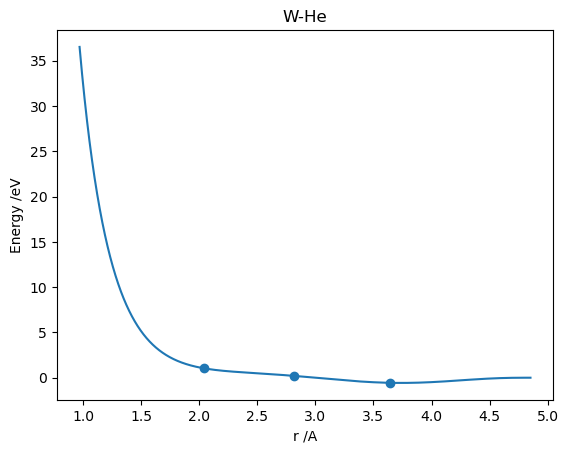

In [106]:
k = 1000
zbl = ZBL(2,74)

key = 'W-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(sample[inst.map[key]['knot_pts']], sample[inst.map[key]['knot_val']] + zbl.eval_zbl(sample[inst.map[key]['knot_pts']]))

plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Energy /eV')

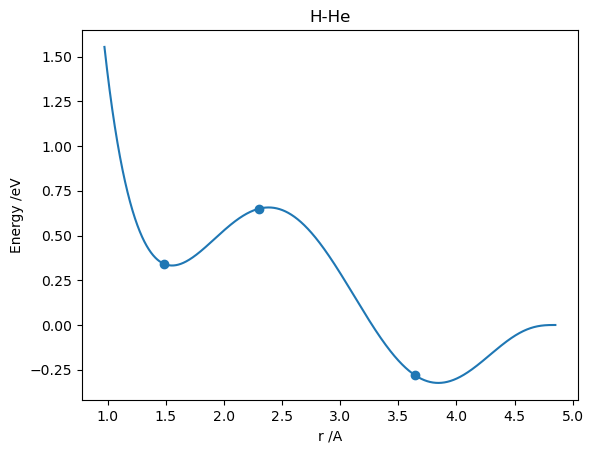

In [107]:
k = 1000
zbl = ZBL(2,1)
key = 'H-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(sample[inst.map['H-He']['knot_pts']], sample[inst.map['H-He']['knot_val']] + zbl.eval_zbl(sample[inst.map['H-He']['knot_pts']]))
plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Energy /eV')

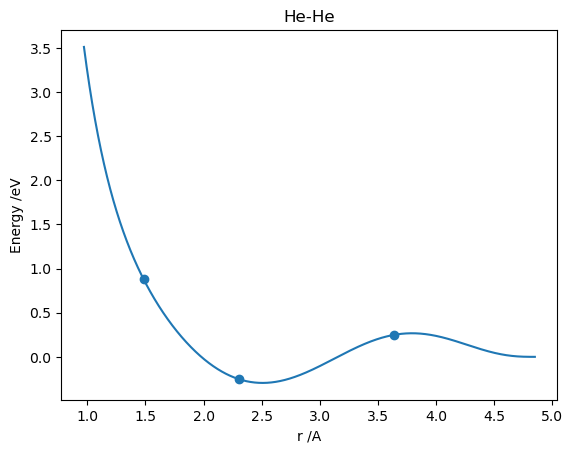

In [108]:
k = 1000
zbl = ZBL(2,2)

key = 'He-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(sample[inst.map[key]['knot_pts']], sample[inst.map[key]['knot_val']] + zbl.eval_zbl(sample[inst.map[key]['knot_pts']]))

plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')